# Tech assessment DuckDuckGoose - RWVOS

The idea of this assessment is to incorporate all elements of a deep learning pipeline:
1. Exploring the dataset
2. Optional pre-processing and cleaning of the dataset, if necessary
3. Find the best model for the task 

Don't forget to activate the GPU available through Google Colab. If you have a GPU on your local computer, good for you. Just don't forget to use it. 

We do encourage you to use Pytorch, as this is the library mostly used by DuckDuckGoose, but if you are fare more skilled in Tensorflow and want to show off these skills 🤩, don't hestitate to do so. 

Also: we do not expect you to train a model that has 100% accuracy on a test set. This assignment is for you to figure out if you like to work with this kind of data and for us to see if there is a general understanding of the requirements for the eventual project you'll work on 😃

After receiving the assessment, you have 48 hours to complete it. Instruction on how to hand in your work are provided at the bottom on the notebook.

## Introduction to the topic: fake faces!
As you are aware, DuckDuckGoose is concerned with the problem of deepfake detection. Over the years, deepfakes have become harder to distinguish due to risen quality of hardware and software. Luckily for you, there is a dataset with some "old" fake faces to practice!

The task for you is to do a binary classification: are these faces real or fake?

## The dataset 
You can find the dataset here: https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection. The dataset contais roughly 2000 images. We alreay splitted it into train, validation and test sets for you (how nice of us). Per folder, it is divided into two folders: real and fake images.  

You can choose how you want to do the assignment: locally, in a notebook, Google Colab. Completely up to you.

For demonstration purposes, we show how the images look like through a Google Colab implementation. 

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle as pkl

from torchvision import transforms, models
from PIL import Image

from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# check GPU 
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("cpu")
    


In [ ]:
using_colab = False

if using_colab:
    checkpoint_dir = "own_1_run"
    import shutil
    from google.colab import drive, files
    drive.mount('/content/drive', force_remount=True)
    !git clone https://github.com/rwvosTUD/techAss.git
    tbzip_folder="/content/{0}_z.zip".format(checkpoint_dir)
    zip_folder = "/content/{0}".format(checkpoint_dir)
    real = "/content/drive/MyDrive/detection_dataset/train/real/"
    fake = "/content/drive/MyDrive/detection_dataset/train/fake/"
    real_val = "/content/drive/MyDrive/detection_dataset/val/real/"
    fake_val = "/content/drive/MyDrive/detection_dataset/val/fake/"
    real_test = "/content/drive/MyDrive/detection_dataset/test/real/"
    fake_test = "/content/drive/MyDrive/detection_dataset/test/fake/"
    import techAss.utilityV1 as util
else:
    real = "detection_dataset/train/real/"
    fake = "detection_dataset/train/fake/"
    real_val = "detection_dataset/val/real/"
    fake_val = "detection_dataset/val/fake/"
    real_test = "detection_dataset/test/real/"
    fake_test = "detection_dataset/test/fake/"
    import utilityV1 as util
real_path = os.listdir(real)
fake_path = os.listdir(fake)

real_path_val = os.listdir(real_val)
fake_path_val= os.listdir(fake_val)

real_path_test = os.listdir(real_test)
fake_path_test = os.listdir(fake_test)

## Chapter 1: Data analysis

### Section 1.1: visual inspection
<br> Notes:
- Visual inspection of data sets do not raise any concerns for clear anomalies (e.g. completely green images) which could skew the model's performance.
- visual inspection suggests that real and fake images can often be distinguished by a 'sudden' change in pixel value i.e. a non-smooth conversion. This might suggest that converting the images to greyscale might be a worthwhile avenue to consider to combat overfitting. 


In [ ]:
print("real images")
fig = plt.figure(figsize=(4, 4))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(util.load_img(real + real_path[i]), cmap='gray')    
    plt.axis('off')
plt.show()

print("fake images")
fig = plt.figure(figsize=(4, 4))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(util.load_img(fake + fake_path[i]), cmap='gray')    
    plt.axis('off')
plt.show()

### Section 1.2: Dataset inspection
Label ratios to check for imbalance during training
<br>Notes:
- Training set is slightly imbalanced, yet not considerably. However benchmark of model should not be considered at 50%. Therefore the threshold computed in the next cell is used later to define a predictions label.
- The fact that the imbalance is not large suggests no need for further increase of any labels' samples through data augmentation techniques such as cropping, flipping etc.

In [ ]:
n_real = len(real_path)
n_fake = len(fake_path)
threshold = n_fake/(n_fake+n_real)
print("Training data set division = real/fake = {0}/{1} = {2} %".format(n_real,n_fake,round(threshold*100,1)))

n_real_val = len(real_path_val)
n_fake_val = len(fake_path_val)
threshold_val = n_fake_val/(n_fake_val+n_real_val)
print("Validation data set division = real/fake = {0}/{1} = {2} %".format(n_real_val,n_fake_val,round(threshold_val*100,1)))

n_real_test = len(real_path_test)
n_fake_test = len(fake_path_test)
threshold_test = n_fake_test/(n_fake_test+n_real_test)
print("Test data set division = real/fake = {0}/{1} = {2} %".format(n_real_test,n_fake_test,round(threshold_test*100,1)))

## Chapter 2: Pre-processing the dataset 




The dataset contains real and fake images. It might be possible any form of exploration is desired, to find some important aspects of the images and to see if there is any pre-processing needed: do you want transformations, a certain size? Remind you: not required at all! But do think about this and be able to explain your choices. 

To stimulate the use of Pytorch, we created a Dataset object which can easily be used in combination with the Dataloader. 

You can adapt this with your own transformations, processing etc. You can adjust the size of the image if you want to, colours etc: all up to you!

### Section 2.1: Setup dataloader instances
Notice that the datasets have been augmented with an option to also consider greyscale/black-white pixels. When in RGB mode the images are in scale [0,1] so already considered standardized.

In [ ]:
if using_colab:
    dir_name = "/content/drive/MyDrive/detection_dataset/" 
else:
    dir_name = "./detection_dataset/"
img_conversion = "RGB" 
dataset_train = util.RealOrFakeDataset(dir_name, "train", img_conversion = img_conversion)
data_train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_val = util.RealOrFakeDataset(dir_name, "val",img_conversion = img_conversion)
data_val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)

dataset_test= util.RealOrFakeDataset(dir_name, "test",img_conversion = img_conversion)
data_test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

sample,label = next(iter(data_train_loader))
sample.shape # RGB (224x224)

## Chapter 3: Neural networks definitions

Your task is to implement at least two different models:
1. Create a small neural network. Just a few layers. Create the neural network architecture yourself and code it yourself (using PyTorch or Tensorflow ofcourse). 
2. Choose 1 or 2 existing model architectures.  

The goal is to train all networks and compare performances on the test set. 

For the neural network, it is allowed to use already existing code (no need to re-invent the wheel). But again: be able to explain the reason behind it. Why are you using ReLU instead of sigmoid? Why are you using a batch normalisation layer or add drop-out?

Think about the metrics you would like to use: is it accuracy, F1-score, AMP? Or a combinations of a few metrics?

## Section 3.1: Simple neural network
<br> Design choices  (result of iterative tuning):
- Convolution layers: Image data contains features which should be considered in a location invariant manner. Convolution layers are capable of capturing features regardless of the location through a characteristic called weight sharing.
    - ReLu: in intermediary layers this activation function provides a good gradient for the loss to be backpropagated across.
    - Filter size 3x3: the size is chosen as to be not too big to miss any features. Due to max pooling and larger convolutions details might become less important which is actually of paramount importance for this assignment. 
    - No strides: together with the max pooling the field-of-view of the cnn layers is already considered diminished.
    - Filter amount: increases as we move through the network, this is because in the first layers & inputs the filters often focus on basic features (e.g. edges/lines), but as we move further in the network more detailed features are encountered which are best evaluated through a larger amount of filters. In other words this is because these later intermediary layers' outputs are often more distinguishable and more filters can thus pick up on more features.
- Max pooling: efficiency memory use and can accentuate differences/key parts in the filters. The stride and pool size are chosen by convention, but do make sense as they should be able to accentuate, yet not limit the network too much wrt discarded data.
- Linear layers: four linear layers with ReLu are chosen to slowly reduce to a single classifying output. This structure of unit numbers is chosen not to create a potential bottleneck. Sigmoid final layer to push the output into a format [-1,1]. The sigmoid gradient is not deemed desireable for layers before the last one.
- Batch normalization: NN work best with standardized inputs and BN tries to impose this on intermediary layers as well. This is applied especially to the convolution *earlier* layers which should gain the most from BN as an overfitting-combatting technique as earlier layers might show a more pronounced difference between batches. It is thought that the final layers of the network should have diminished these sample differences making it less useful there.
- Dropout: to fight overfitting these are applied to the linear layers which are deemed . Convolution layers already have an inherent overfitting-combatting feature in their weight sharing property so it seems overkill to apply this there. Furthermore, dropout of weights can make an entire filter less useful, which is not deemed to aid the objective. Dropout of 20% is conventional, no reason to stray away from this.

<br> Final note: the aim of this model was to keep it smaller and trainable such that I can quickly assess and rearange layers. Furthermore, notice that I intended to avoid a bottleneck. This architecture is a result of preliminary tests which indicates that smaller networks were underfitting on training data and larger networks did not improve out-of-sample score. 

In [ ]:
class NeuralNet(nn.Module):
    '''
    This class contains all functions required for 
    a custom neural network architecture
    '''
    
    def __init__(self, use_batchnorm = False, use_dropout = False):
        '''
        Initialize the networks layers
        Args:
            use_batchnorm: whether to use batch normalization
            use_dropout: whether to use dropout
        '''
        super(NeuralNet, self).__init__()
        
        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout
        
        self.conv1 = nn.Conv2d(3,16,3)
        self.mp1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,3)
        self.conv3 = nn.Conv2d(32,64,3)
        self.conv4 = nn.Conv2d(64,64,3)
        
        self.conv_bn1=nn.BatchNorm2d(16)
        self.conv_bn2=nn.BatchNorm2d(32)
        
        self.dropout1=nn.Dropout(p = 0.2)
        self.dropout2=nn.Dropout(p = 0.2)
        
        #'''
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        #'''

    def forward(self,x):
        '''
        Forward pass definition as required by pytorch
        '''
        x = self.mp1(F.relu(self.conv1(x)))
        if self.use_batchnorm:
            x = self.conv_bn1(x)
        x = self.mp1(F.relu(self.conv2(x)))
        if self.use_batchnorm:
            x = self.conv_bn2(x)
        x = self.mp1(F.relu(self.conv3(x)))
        x = self.mp1(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        #'''
        x = F.relu(self.fc1(x))
        if self.use_dropout:
            x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        if self.use_dropout:
            x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = torch.squeeze(x)
        #x = self.fc3(x)
        #'''
        return x

summary(NeuralNet(use_batchnorm = True, use_dropout = True), (3,224,224), device = device)

## Section 3.2: Existing neural network architecture

The objective of this section is to define an existing (large) model structure with pre-trained layers. This should provide a good benchmark to test the model against and speed up the design process by utilizing other designer's training time. 
<br> Design choices (result of iterative tuning):
- Pretrained ResNet50: Out of all models on the pytorch pre-trained models hub, this model is one of the only which is still closer to state of the art. From previous papers read in my previous year I have seen that resnet continuously returns to the forefront (or close to) SOTA, while the others on pytorch website do not>
    - Notice that the resnet layers are frozen and thus not part of the training process. Freezing layers makes sense; features obtained by convolutional layers/networks in earlier layers are often similar regardless of the task at hand. 
    - The bottleneck of TorchVision places the stride for downsampling to the second 3x3 convolution while the original paper places it to the first 1x1 convolution. This variant improves the accuracy and is known as ResNet V1.5. Documentation link: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
- Retrained classifier layers only: Note that cutting of more layers from the back and connecting new classification related deep layers to this is resulted in a much larger bottleneck and also increased the number of parameters considerably. 
- General notes:
    - ResNet is usually use for multi-label image classification across different animals & humans. Therefore I should not expect this model to be all that suited for the task at hand. Online searches for more well-suited pretrained (discriminator) models turned out no considerable models.
    - notice both models now have approximately the same amount of trainable parameters this is done somewhat on purpose but mainly to ensure neither model requires far larger training times than the others

In [ ]:
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        # Cut off classifier (+ last layers) as these where trained for different task
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        
        # freeze pre-trained layers
        for layer in self.resnet.parameters():
            layer.requires_grad = False
        #'''
        # -1
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)
        #'''
        
    
    def forward(self, x):
        x = self.resnet(x)
        x = torch.flatten(x,1)
        #'''
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = torch.squeeze(x)
        #'''
        #x = x.squeeze()
        #x = nn.functional.normalize(x, p=2, dim=1)
        return x
    
summary(ResNetModel(), (3,224,224), device = device)

## Chapter 4: Model training and validation
<br>Details:
- Binary cross entropy loss function: conventional loss function for binary classification. Its log functions provide desireable properties for 
- Metrics tracked:
    - Classification accuracy: using the threshold as defined earlier
    - Precision: ability of the classifier not to label as positive (real) a sample that is negative (fake).
        - for duckduckgoose this clearly is more important since we rather have more images labelled as fake than some fakes slipping through. 
    - Recall: ability to correctly predict the positives out of actual positives. 
    - F1 score: combines recall and precision to distinguish between models which might be better in either of the previous metrics. 
- Models performance is tracked using tensorboard

In [ ]:
# Configuration details
own_model = False # set false for resnet
epochs = 5

In [ ]:
# Create a writer to write to tensorboard
writer = SummaryWriter()

# Inititiate model and optimizers
if own_model:
    net = NeuralNet(use_batchnorm = True, use_dropout = True).to(device)
else:
    net = ResNetModel().to(device)
criterion = nn.BCELoss() # binary cross entropy
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# initiate loss containers
train_metrics_np = np.zeros((epochs,5))
test_metrics_np = np.zeros((epochs,5))

for e in tqdm(range(epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss, train_metrics = util.train_epoch(device, data_train_loader,net,optimizer,criterion, threshold)
    train_loss = train_loss.cpu().detach().item() 
    
    # Test on data
    test_loss, test_metrics = util.test_epoch(device, data_val_loader,net,criterion, threshold)
    test_loss = test_loss.cpu().detach().item() 
    
    # Write metrics to Tensorboard
    writer.add_scalars("Loss", {'Train': train_loss, 'Test':test_loss}, e)            
    writer.add_scalars('Accuracy', {'Train': train_metrics["accuracy"],'Test':test_metrics["accuracy"]} , e)
    writer.add_scalars('Precision', {'Train': train_metrics["precision"],'Test':test_metrics["precision"]} , e)
    writer.add_scalars('Recall', {'Train': train_metrics["recall"],'Test':test_metrics["recall"]} , e)
    writer.add_scalars('F1', {'Train': train_metrics["F1"],'Test':test_metrics["F1"]} , e)

    # save metrics
    train_metrics_np[e,:] = [train_loss, train_metrics["accuracy"],train_metrics["precision"],
                             train_metrics["recall"],train_metrics["F1"]]
    test_metrics_np[e,:] = [test_loss, test_metrics["accuracy"],test_metrics["precision"],
                            test_metrics["recall"],test_metrics["F1"]]
    
    print("Epoch-{0} accuracy: {1} | val acc:{2}".format(e,train_metrics["accuracy"],test_metrics["accuracy"]))

if using_colab:
    # https://stackoverflow.com/questions/52444921/save-numpy-array-using-pickle
    np.savez_compressed('run_data', a=train_metrics_np, b=test_metrics_np)
    shutil.copy("{}_run_data.npz".format(checkpoint_dir), "/content/drive/MyDrive") # save result to drive
else:
    np.savez_compressed('./testData/NEW_data', a=train_metrics_np, b=test_metrics_np)
print('Finished Training')
writer.flush()
writer.close()

Tensorboard code, run in console

In [ ]:
# !tensorboard --logdir runs/ --host localhost

## Chapter 5: Comparison
In order to know which model is most suited for the dataset, you have to compare the models in some way. Visually, numerically: does not matter, as long as you can argument your choice. 

<br> The following figures are presented after training a total of 5 configurations; they include performance metrics for the training and validation set. 4 configurations have been applied to my own neural network to determine whether any of the overfitting features have effect. The last configuration is the ResNet architecture without overfitting features. Note that training ResNet with overfitting features had little effect. It should be noted that the out-of-sample performance is not considered adequate enough to consider a test set comparison and has therefore not been included. In the figures, 'vanilla' indicates no dropout (dp) or batch normalization (bn) is used. The other configurations are defined by their inclusion of bn and/or dp. The results have been cutoff after 180 iterations because no more insightful information was present here.

<br> **Please note that the models proposed in this notebook have been deliberately kept smaller to keep them trainable in a reasonable amount of time. As mentioned to Joris in an email improving performance would involve a more extensive modelling approach and associated configuration testing. I am familiar to substantial designing and tuning procedures, yet hope to limit the rest of this notebook to provide the reader insight into my workflow. Please also remember that the configurations analysed here is already the result of tuning attempts and this analysis focusses more on the effect of overfitting-combatting features.**



### Section 5.1: model results
#### 5.1.1: Training set results:
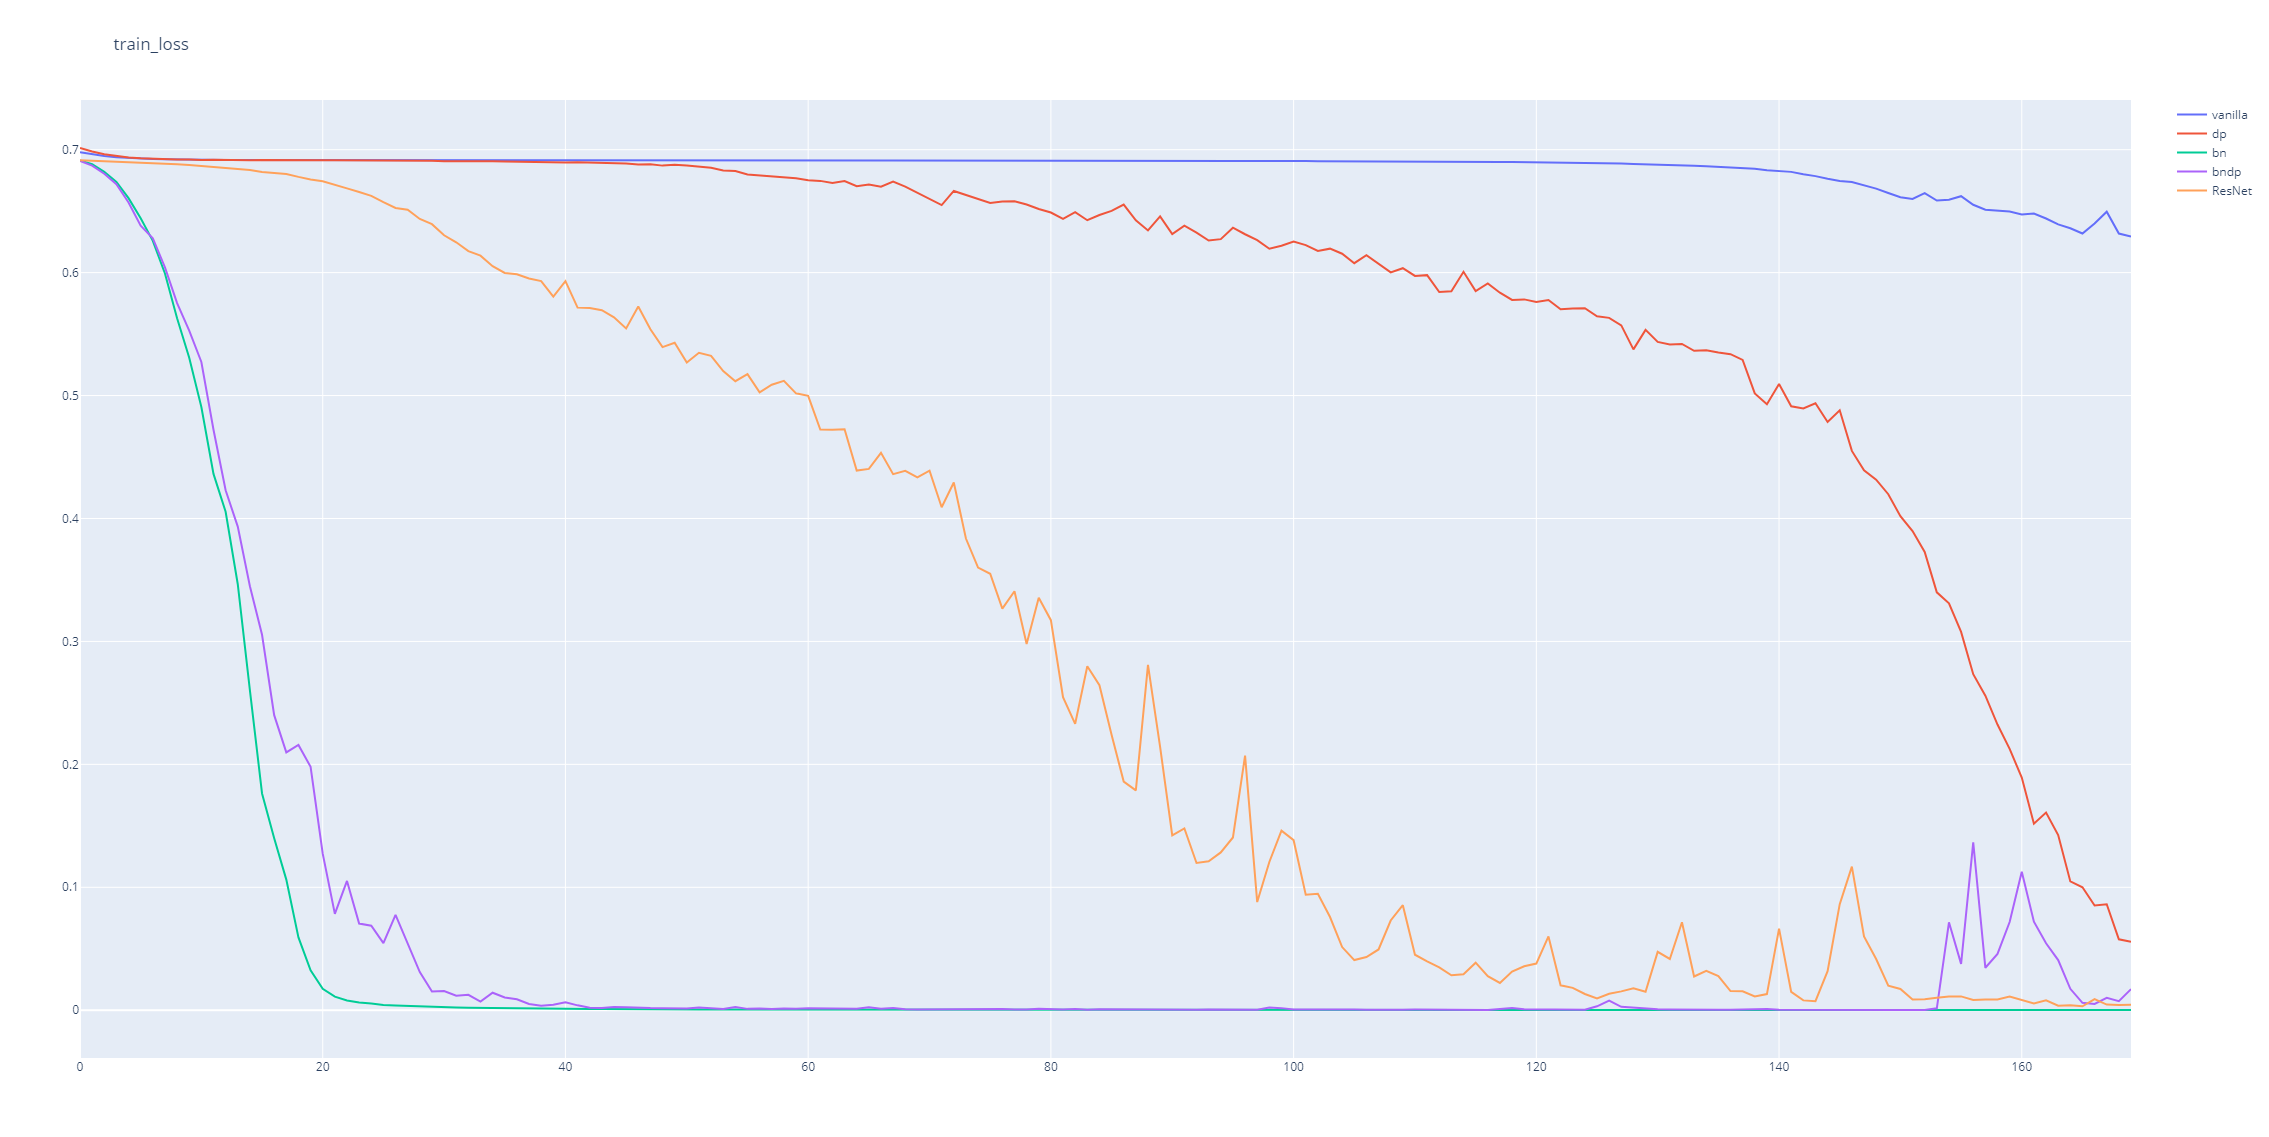
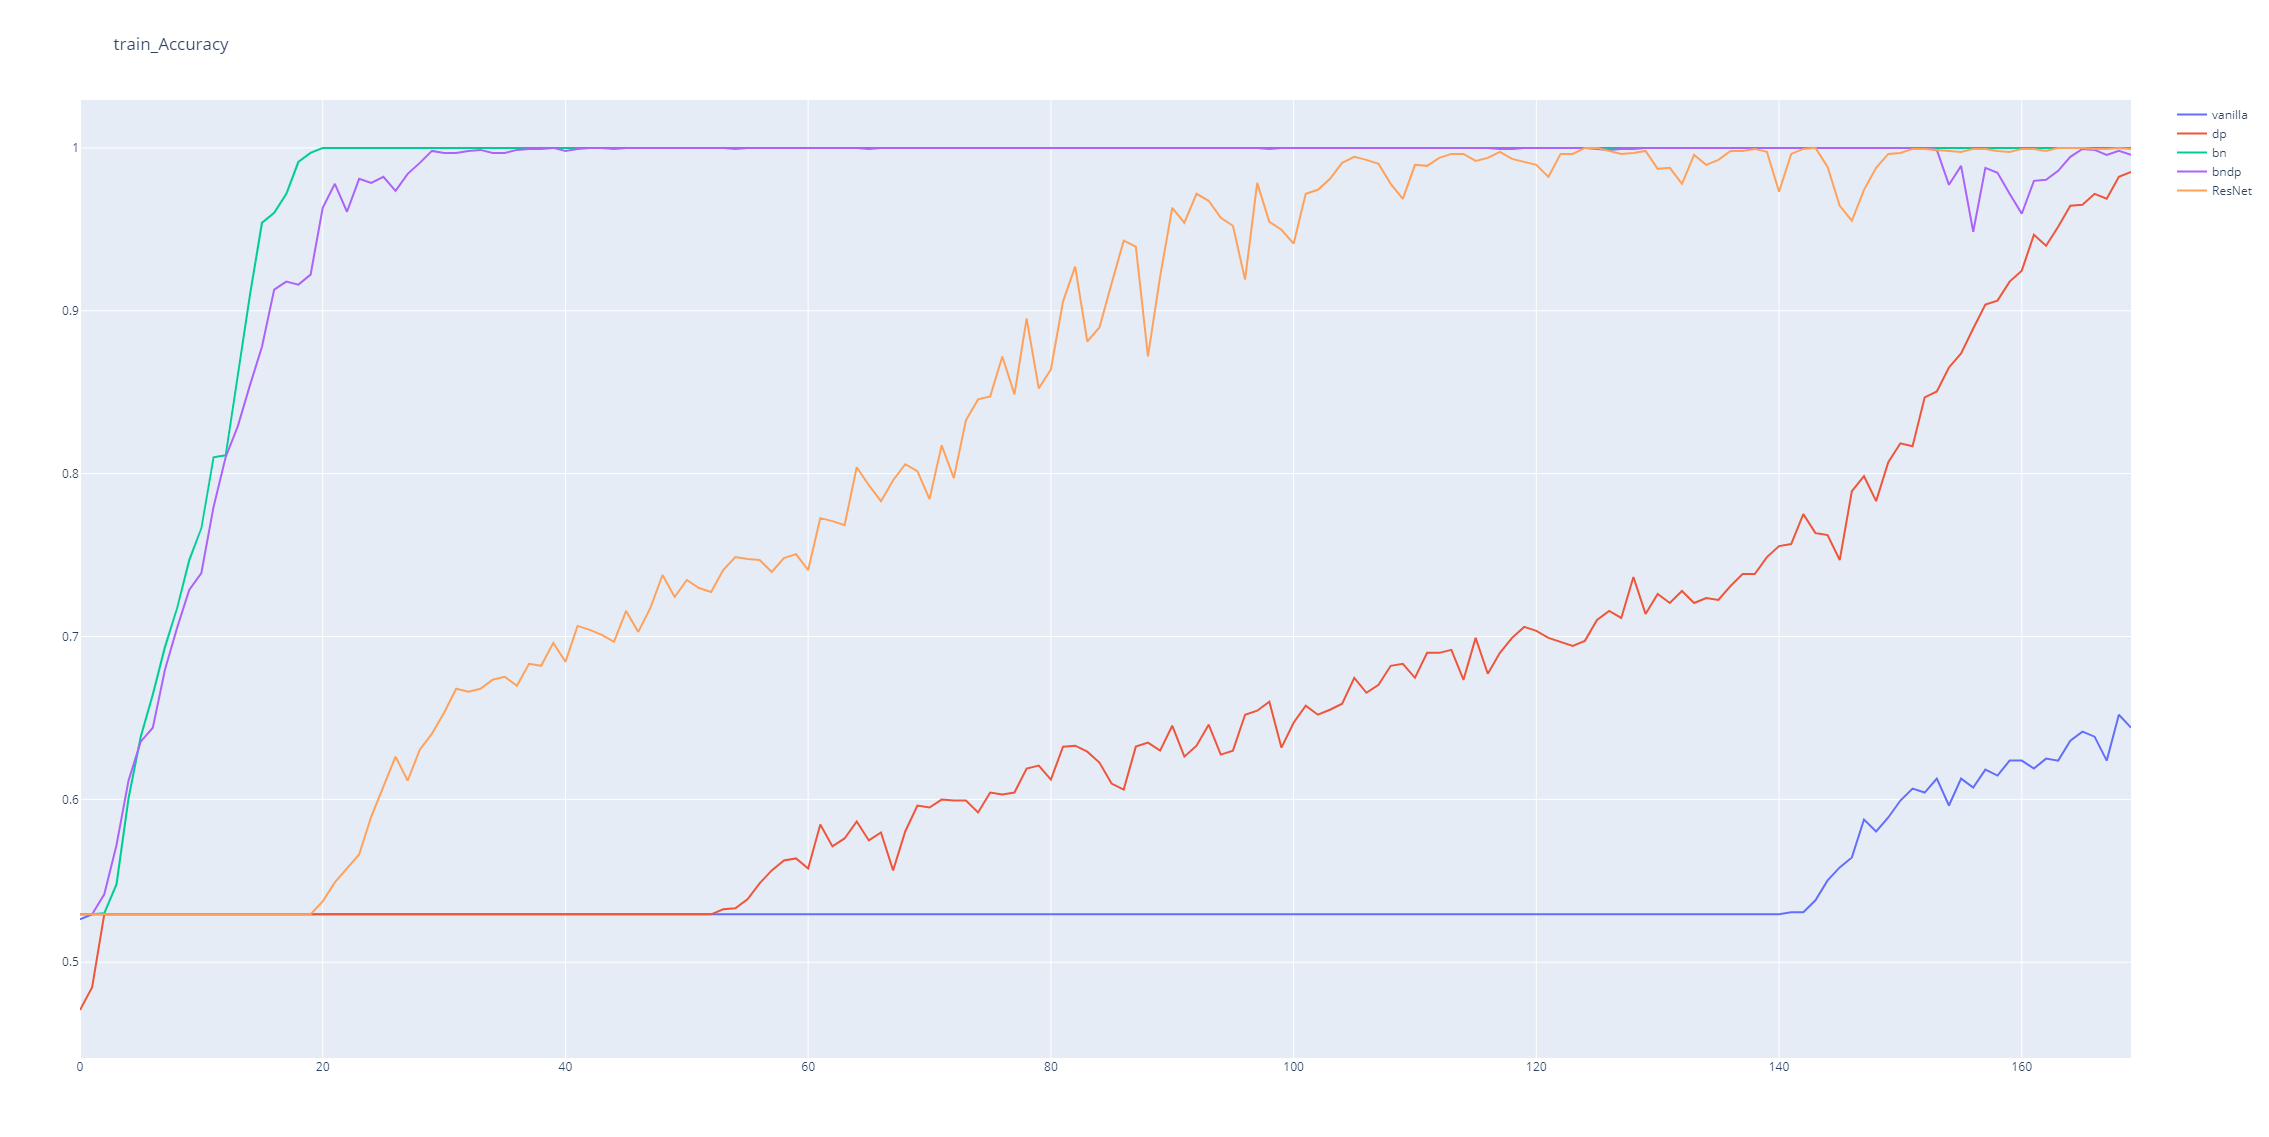
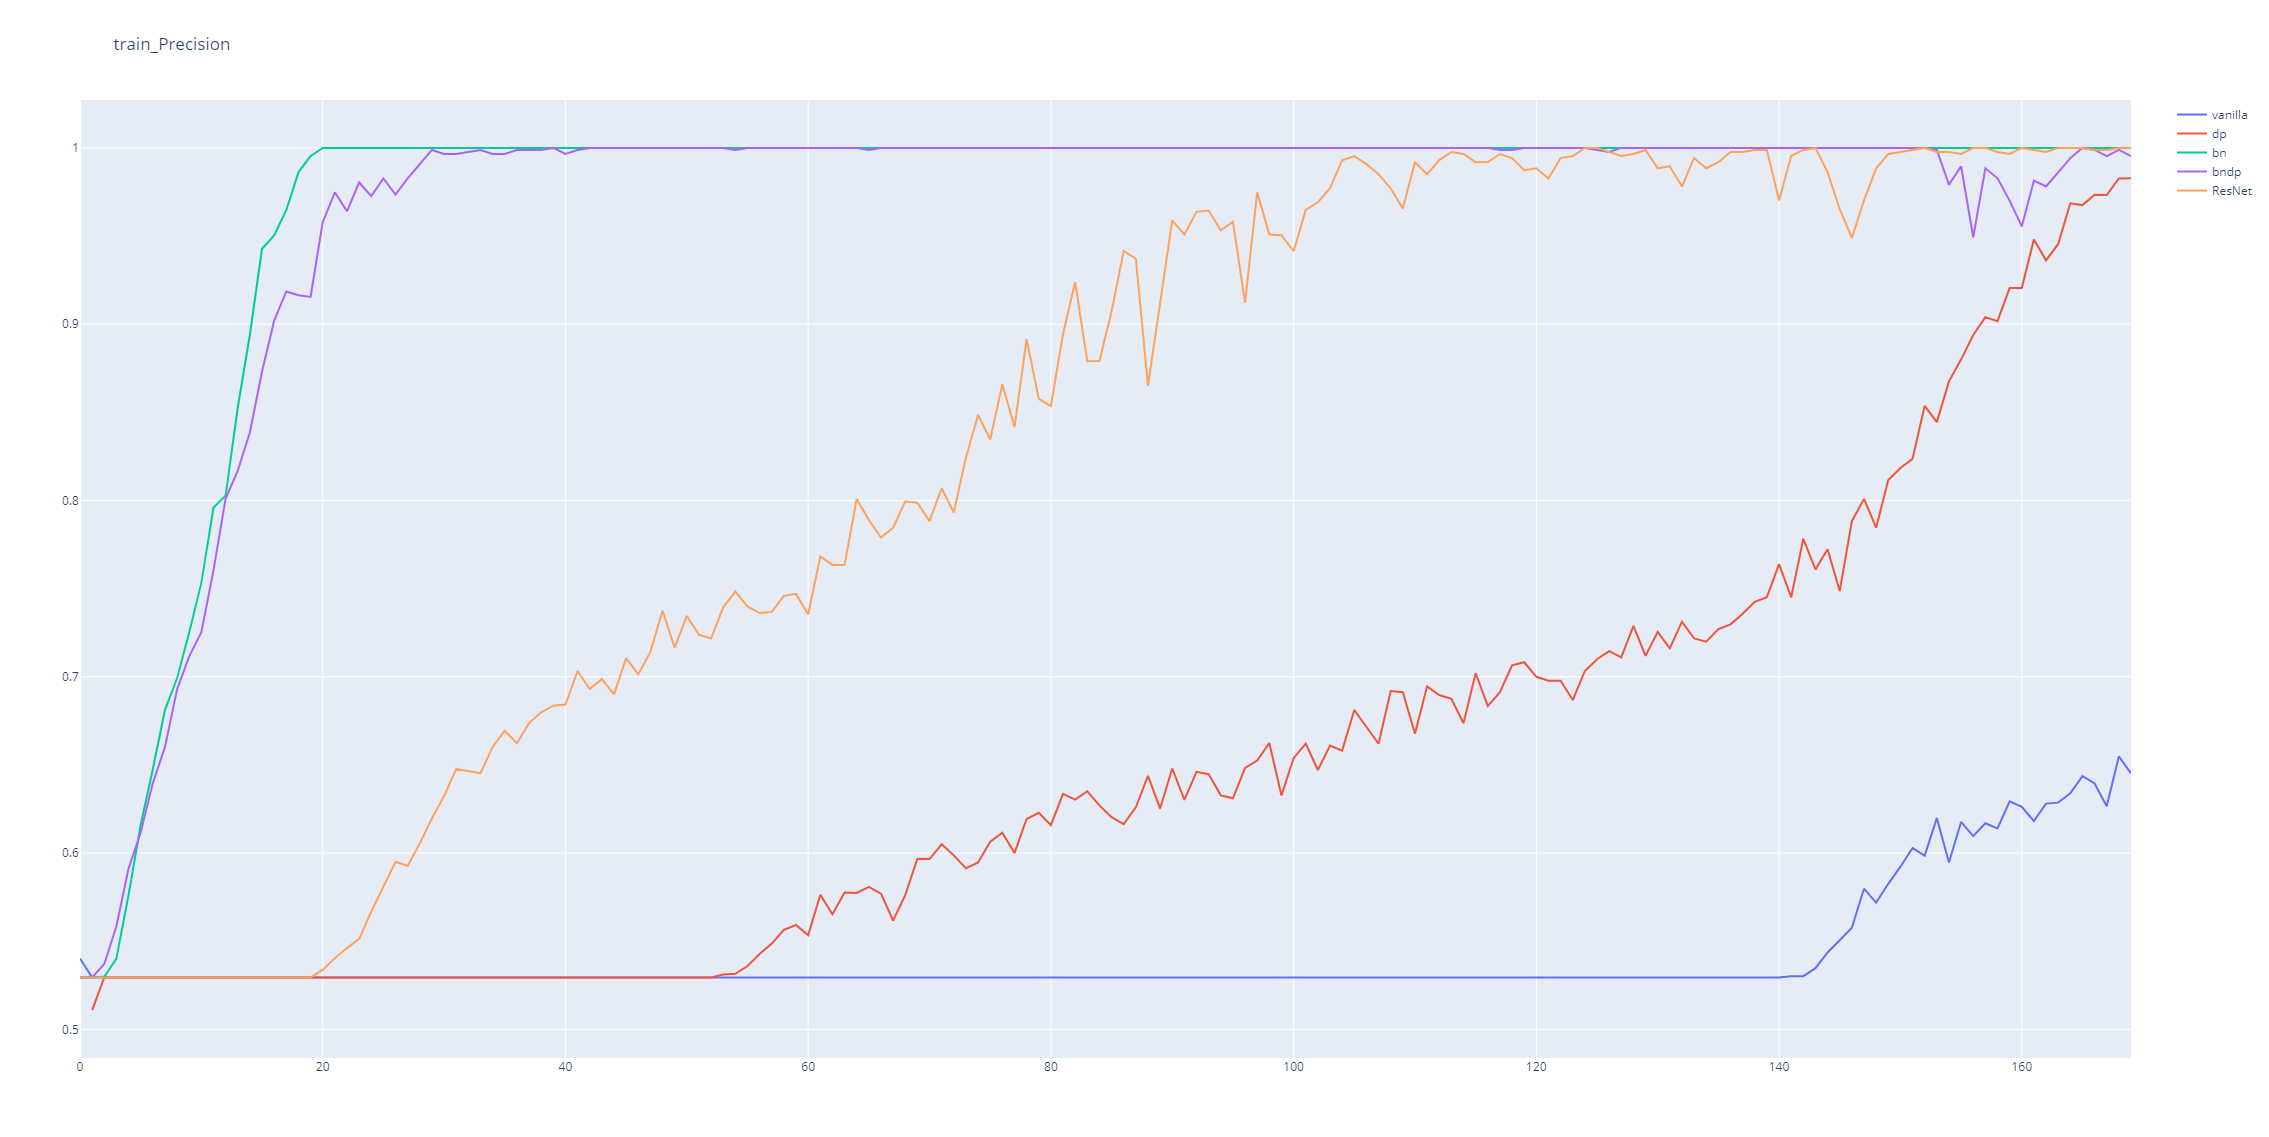
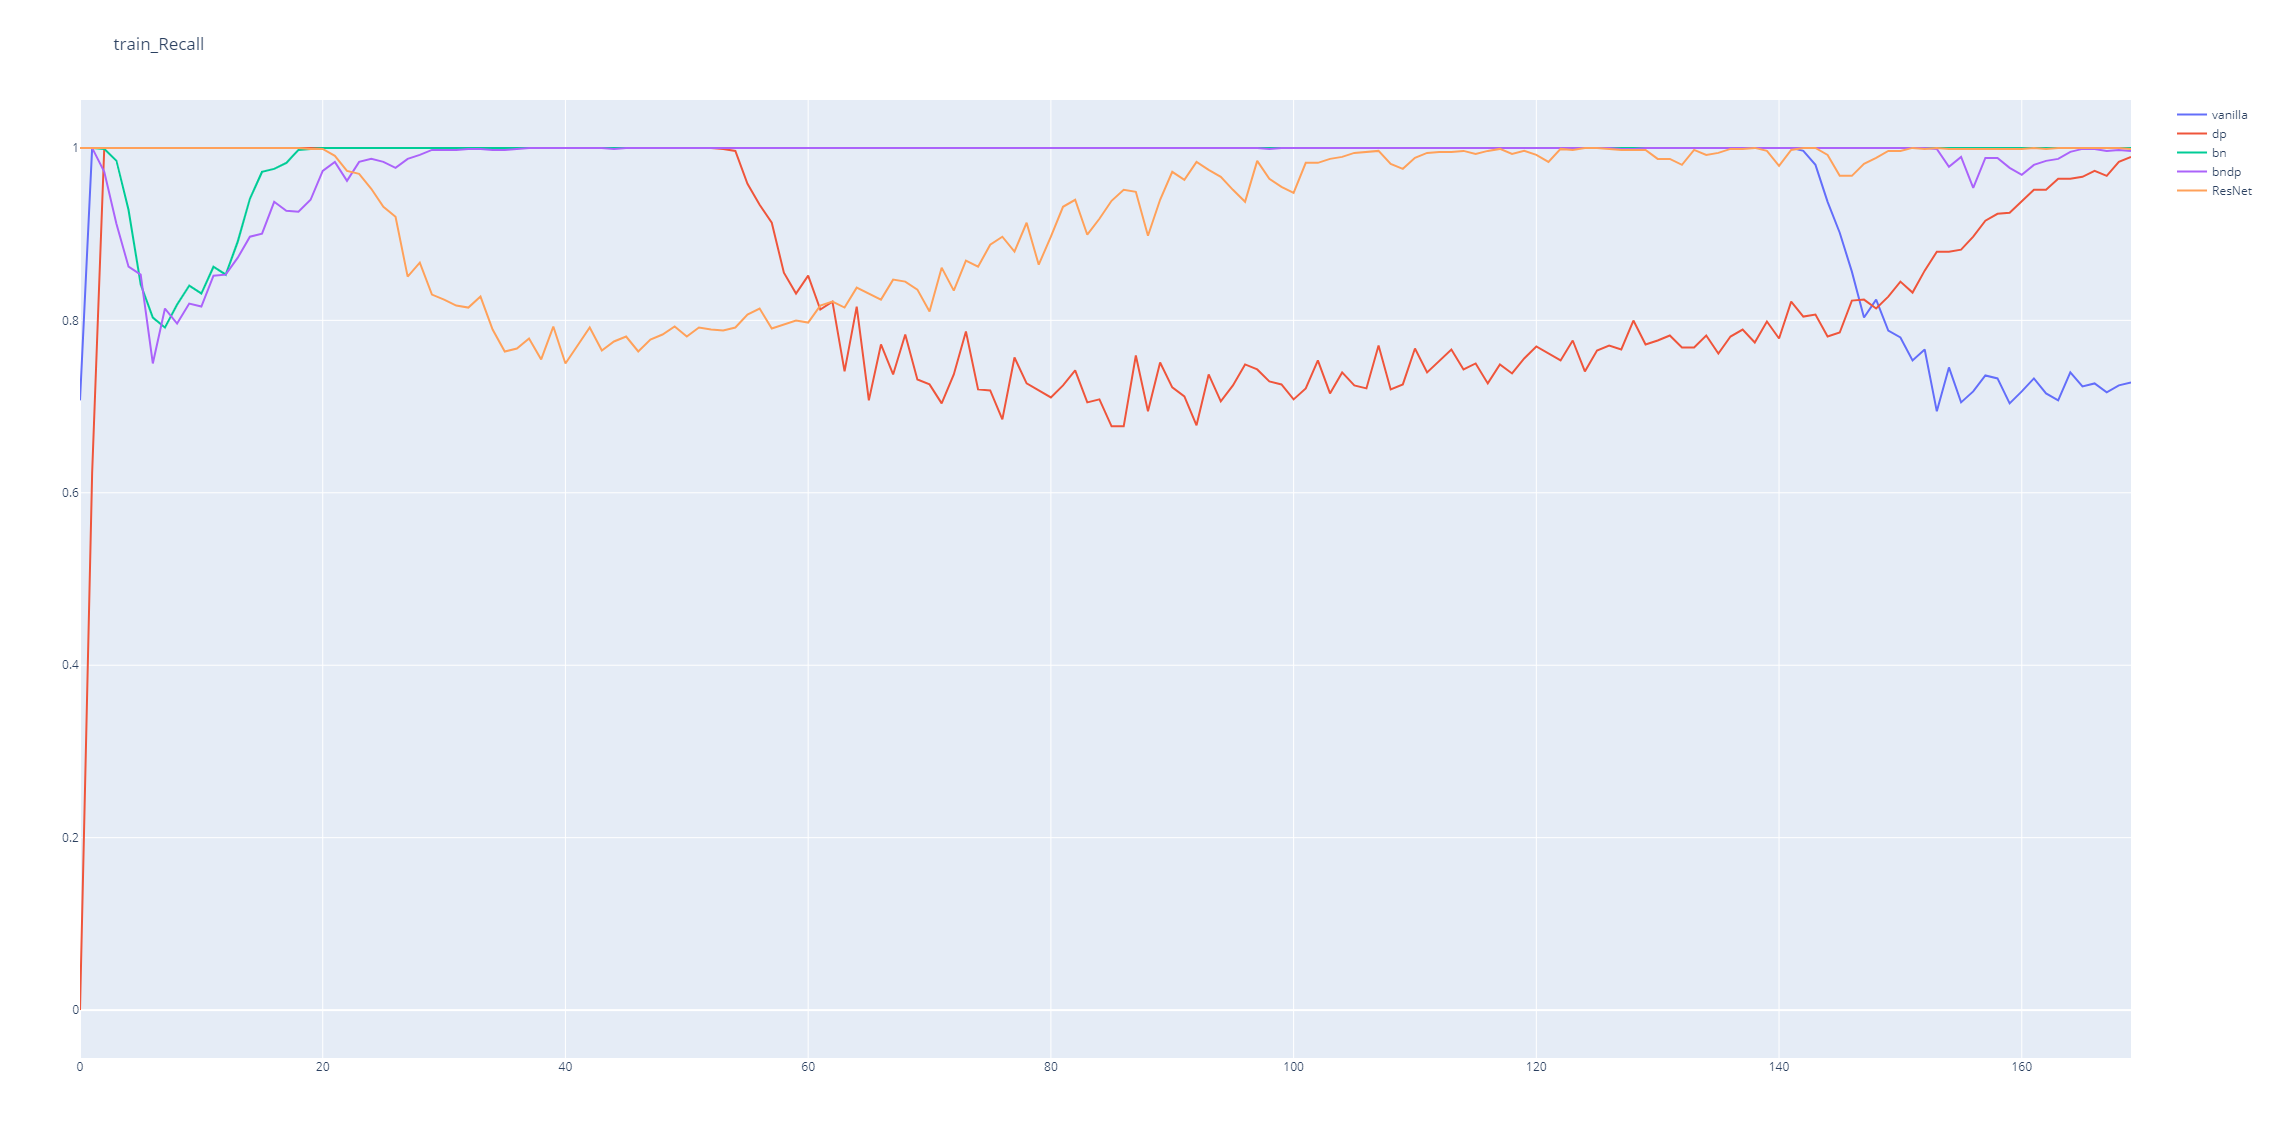
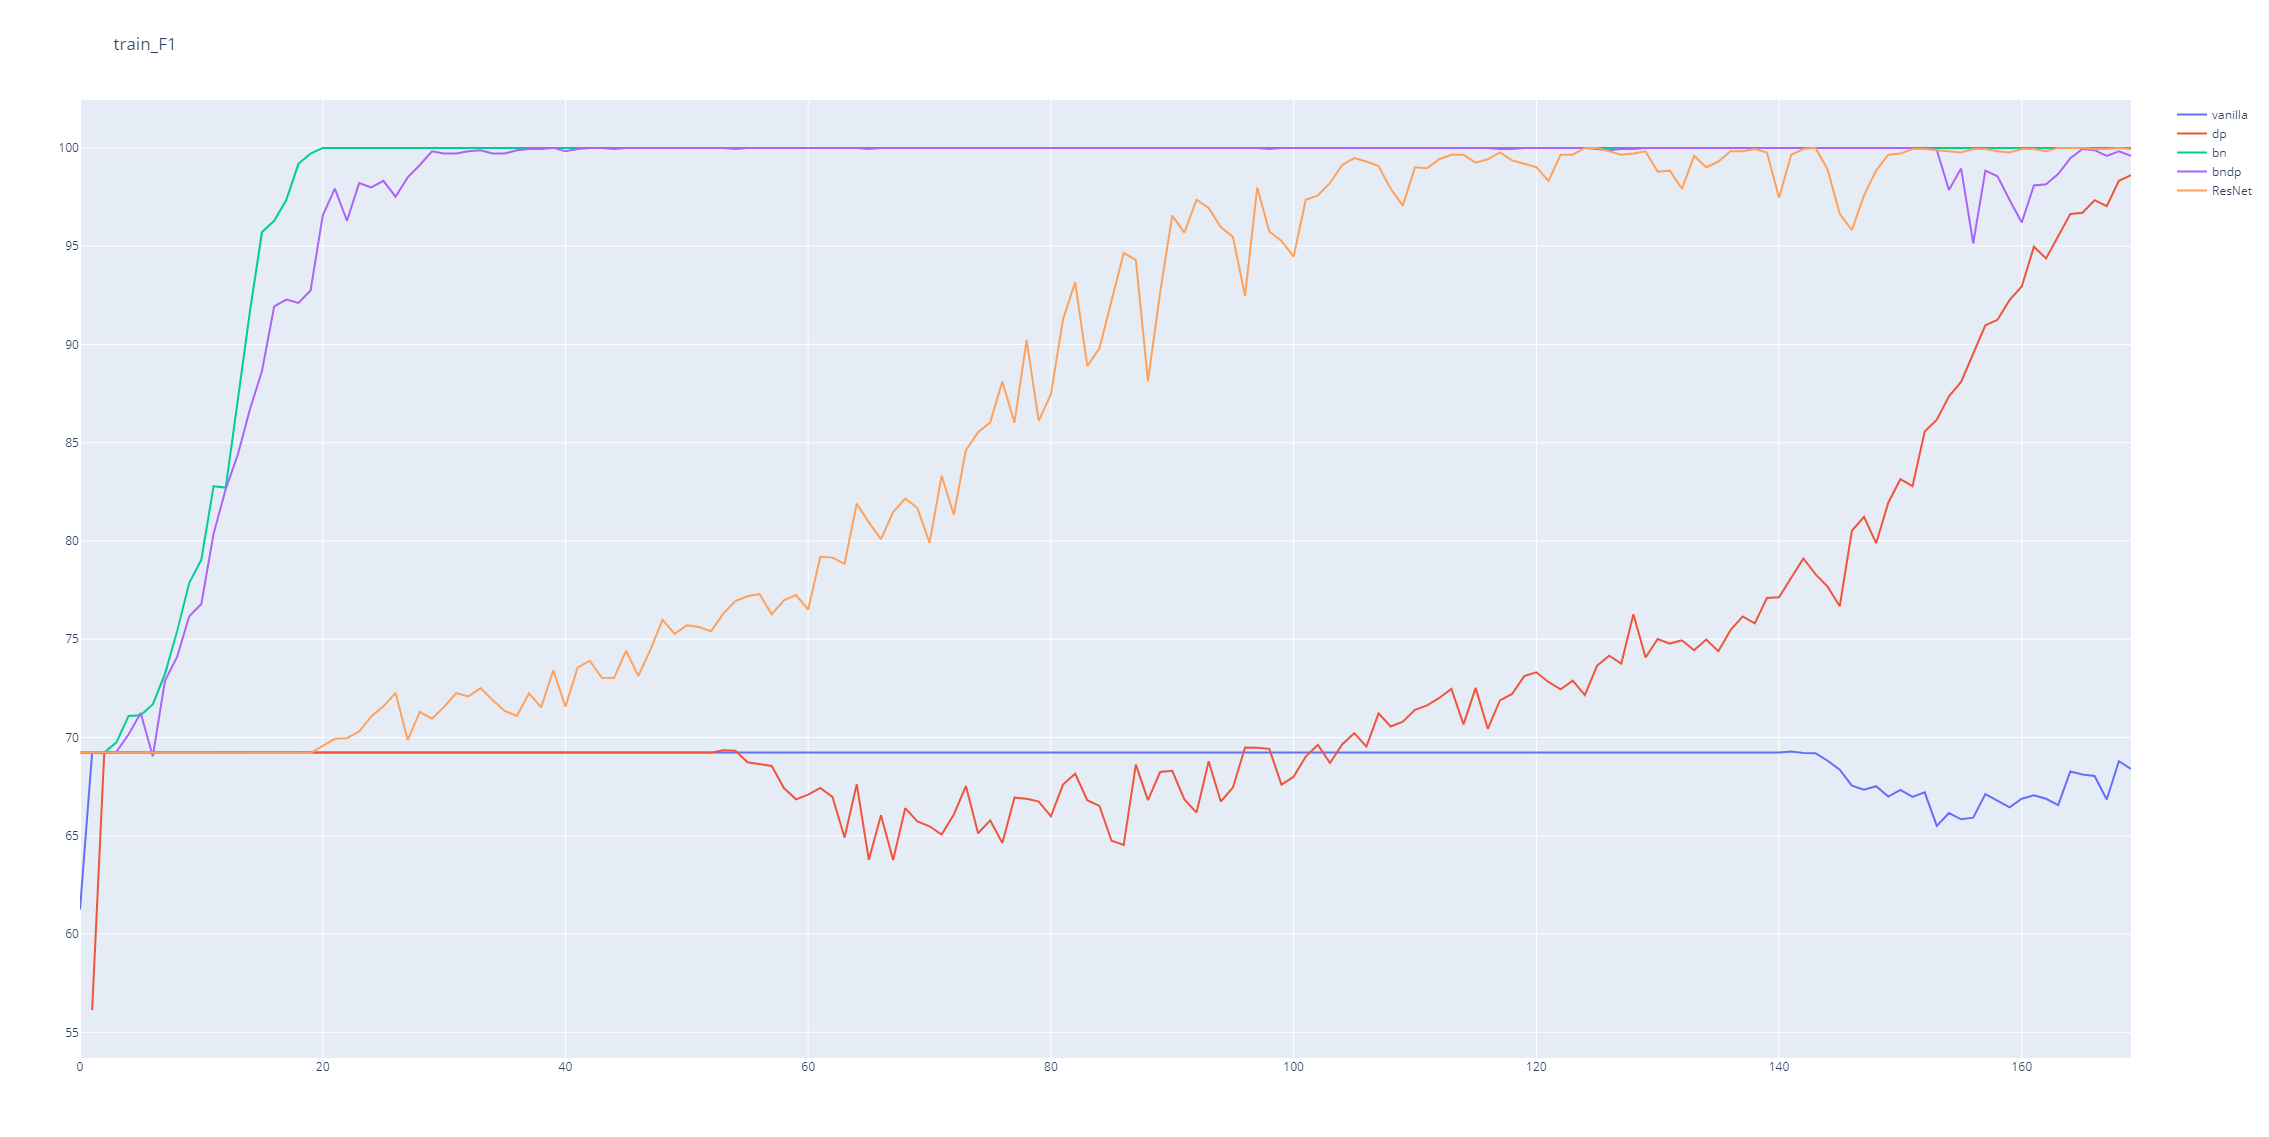
Notice:
- First of all it is clear the models are able to obtain perfect scores on the training sets. Experimental configurations with smaller network sizes were able to obtain these results, yet at a considerably slower pace with no improvement (or even deterioration) on out-of-sample performance. 
- Notice that the models with batch normalization show improved training speed over other (including resnet) configurations. 
- Finally, the losses have clearly configured for all configurations after the set amount of iterations.

#### 5.1.2: Validation set results:
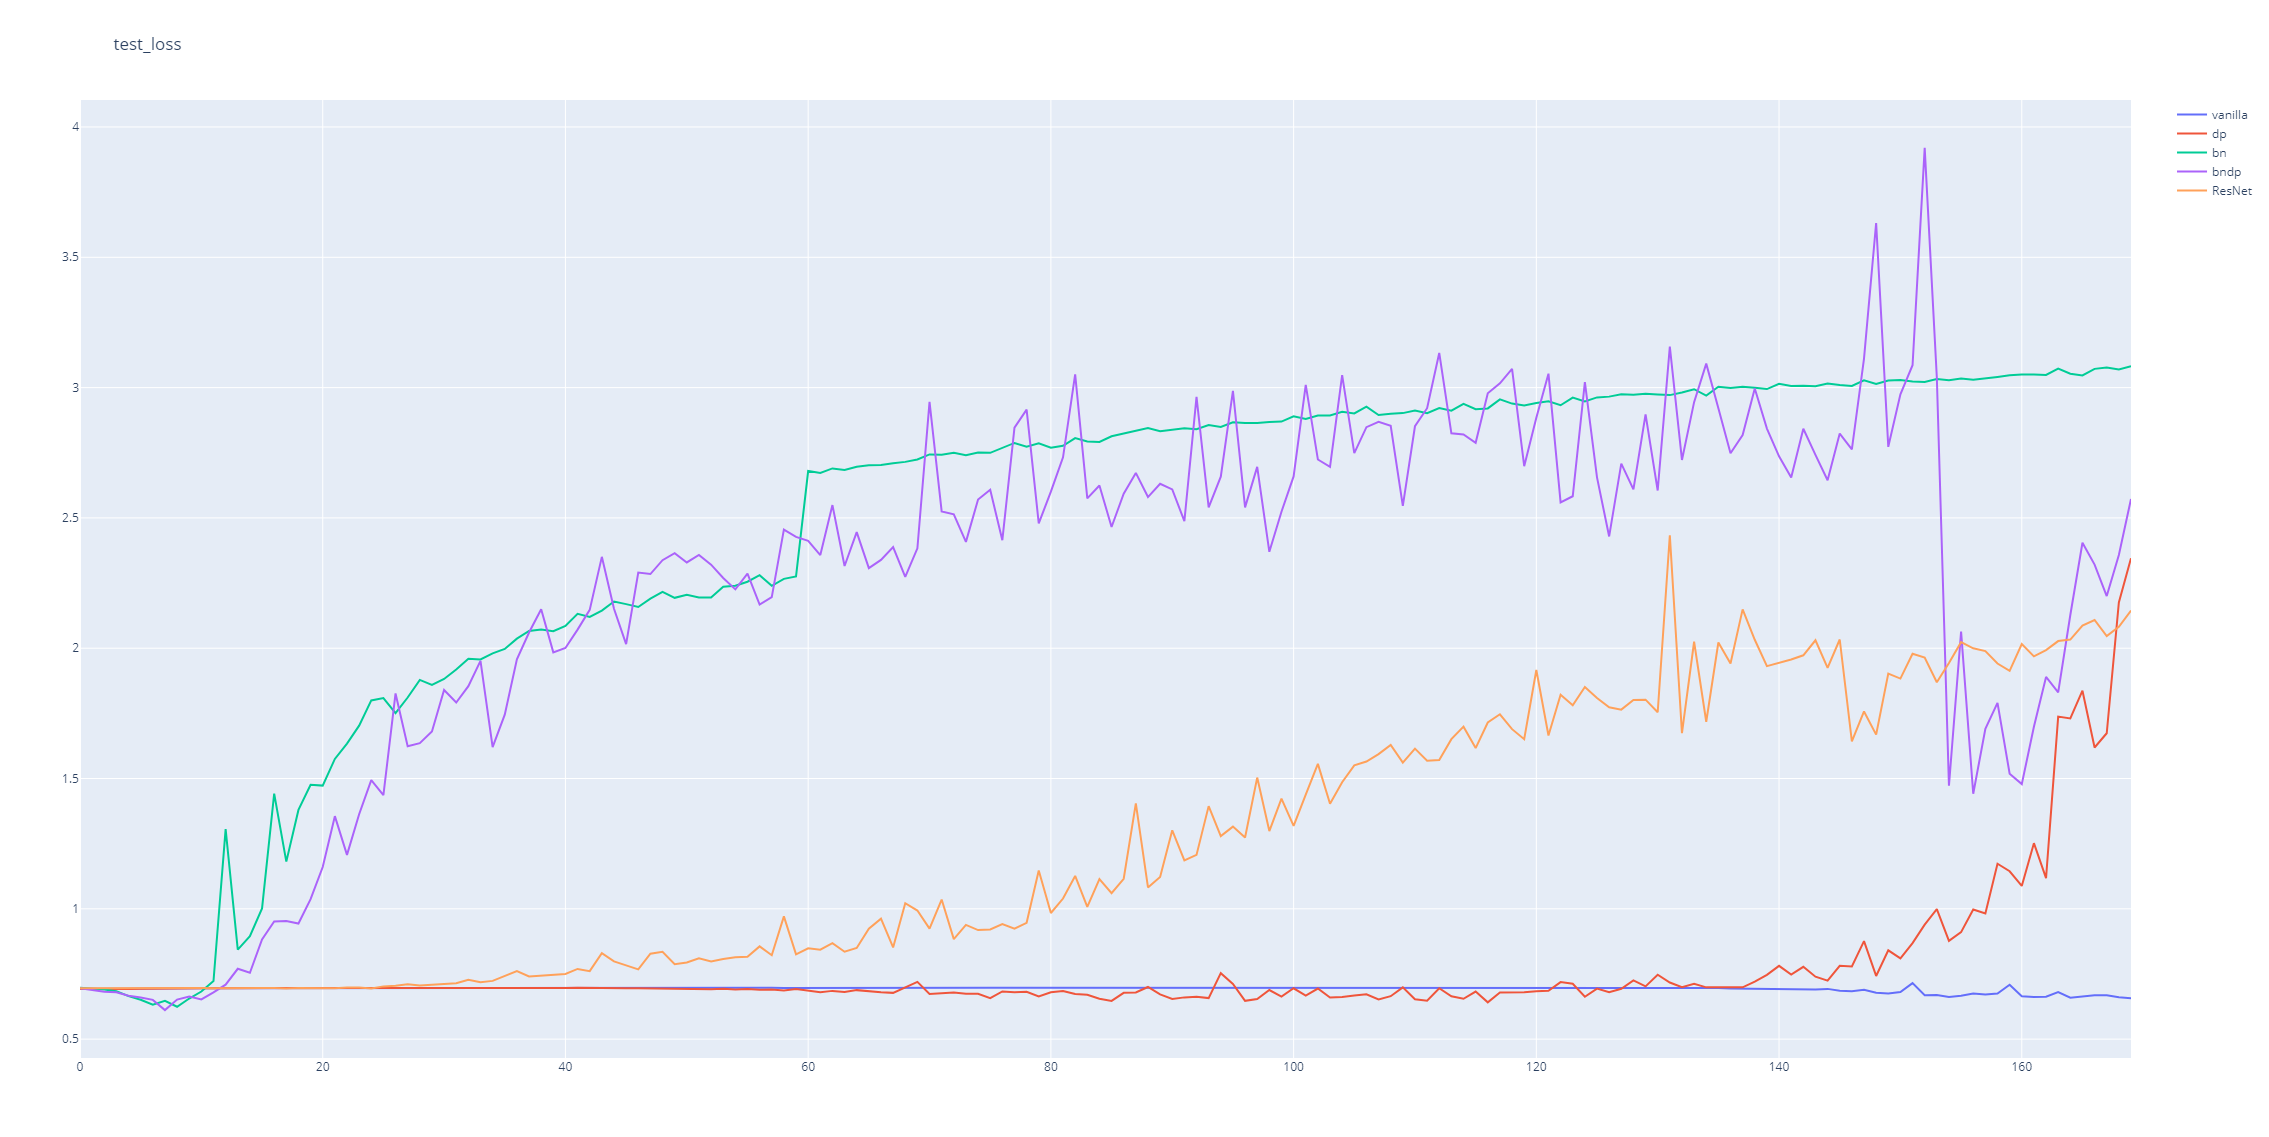
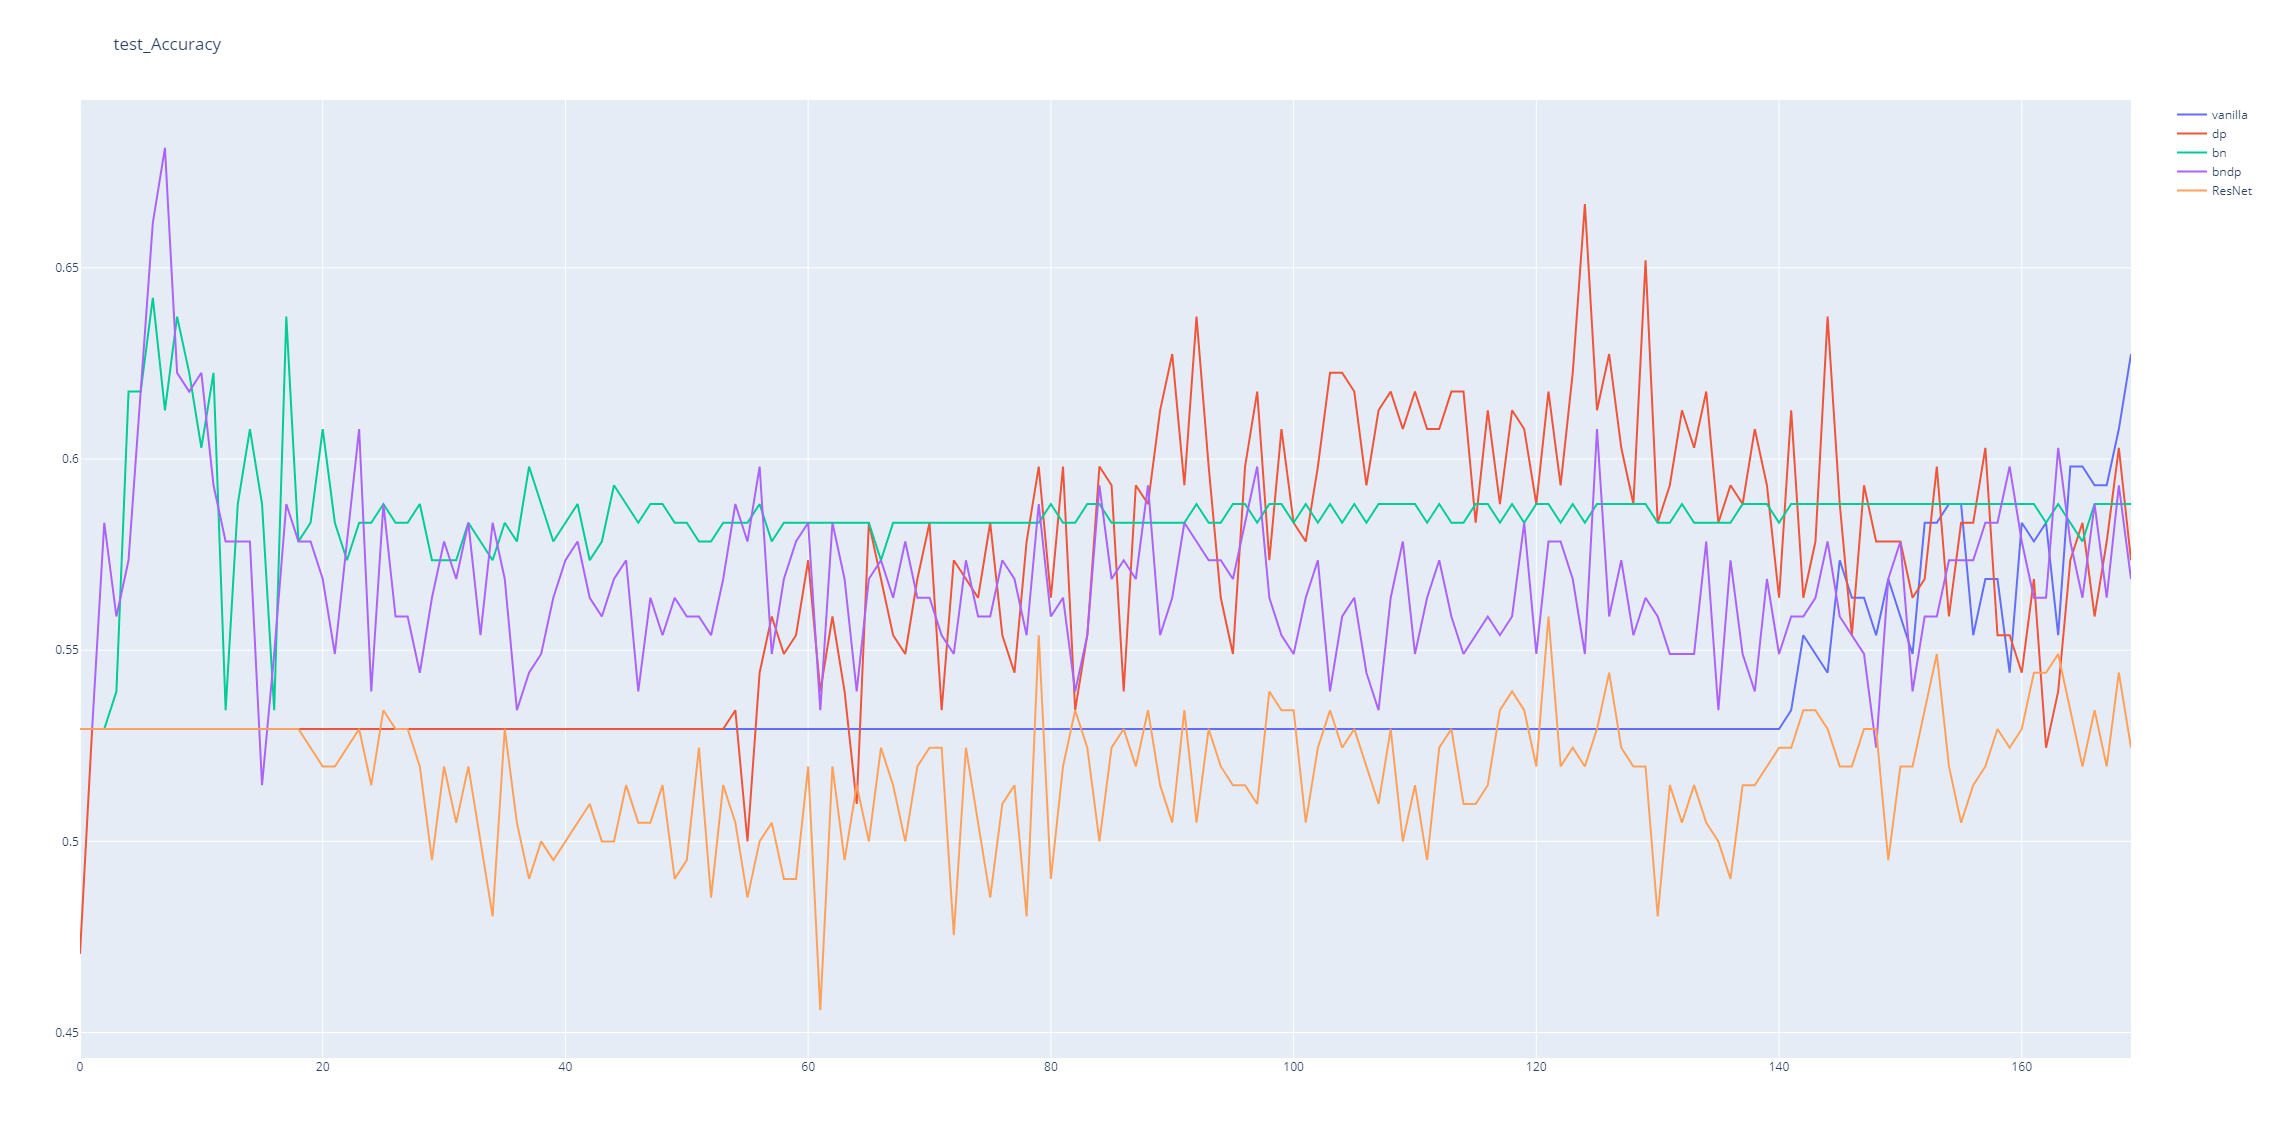
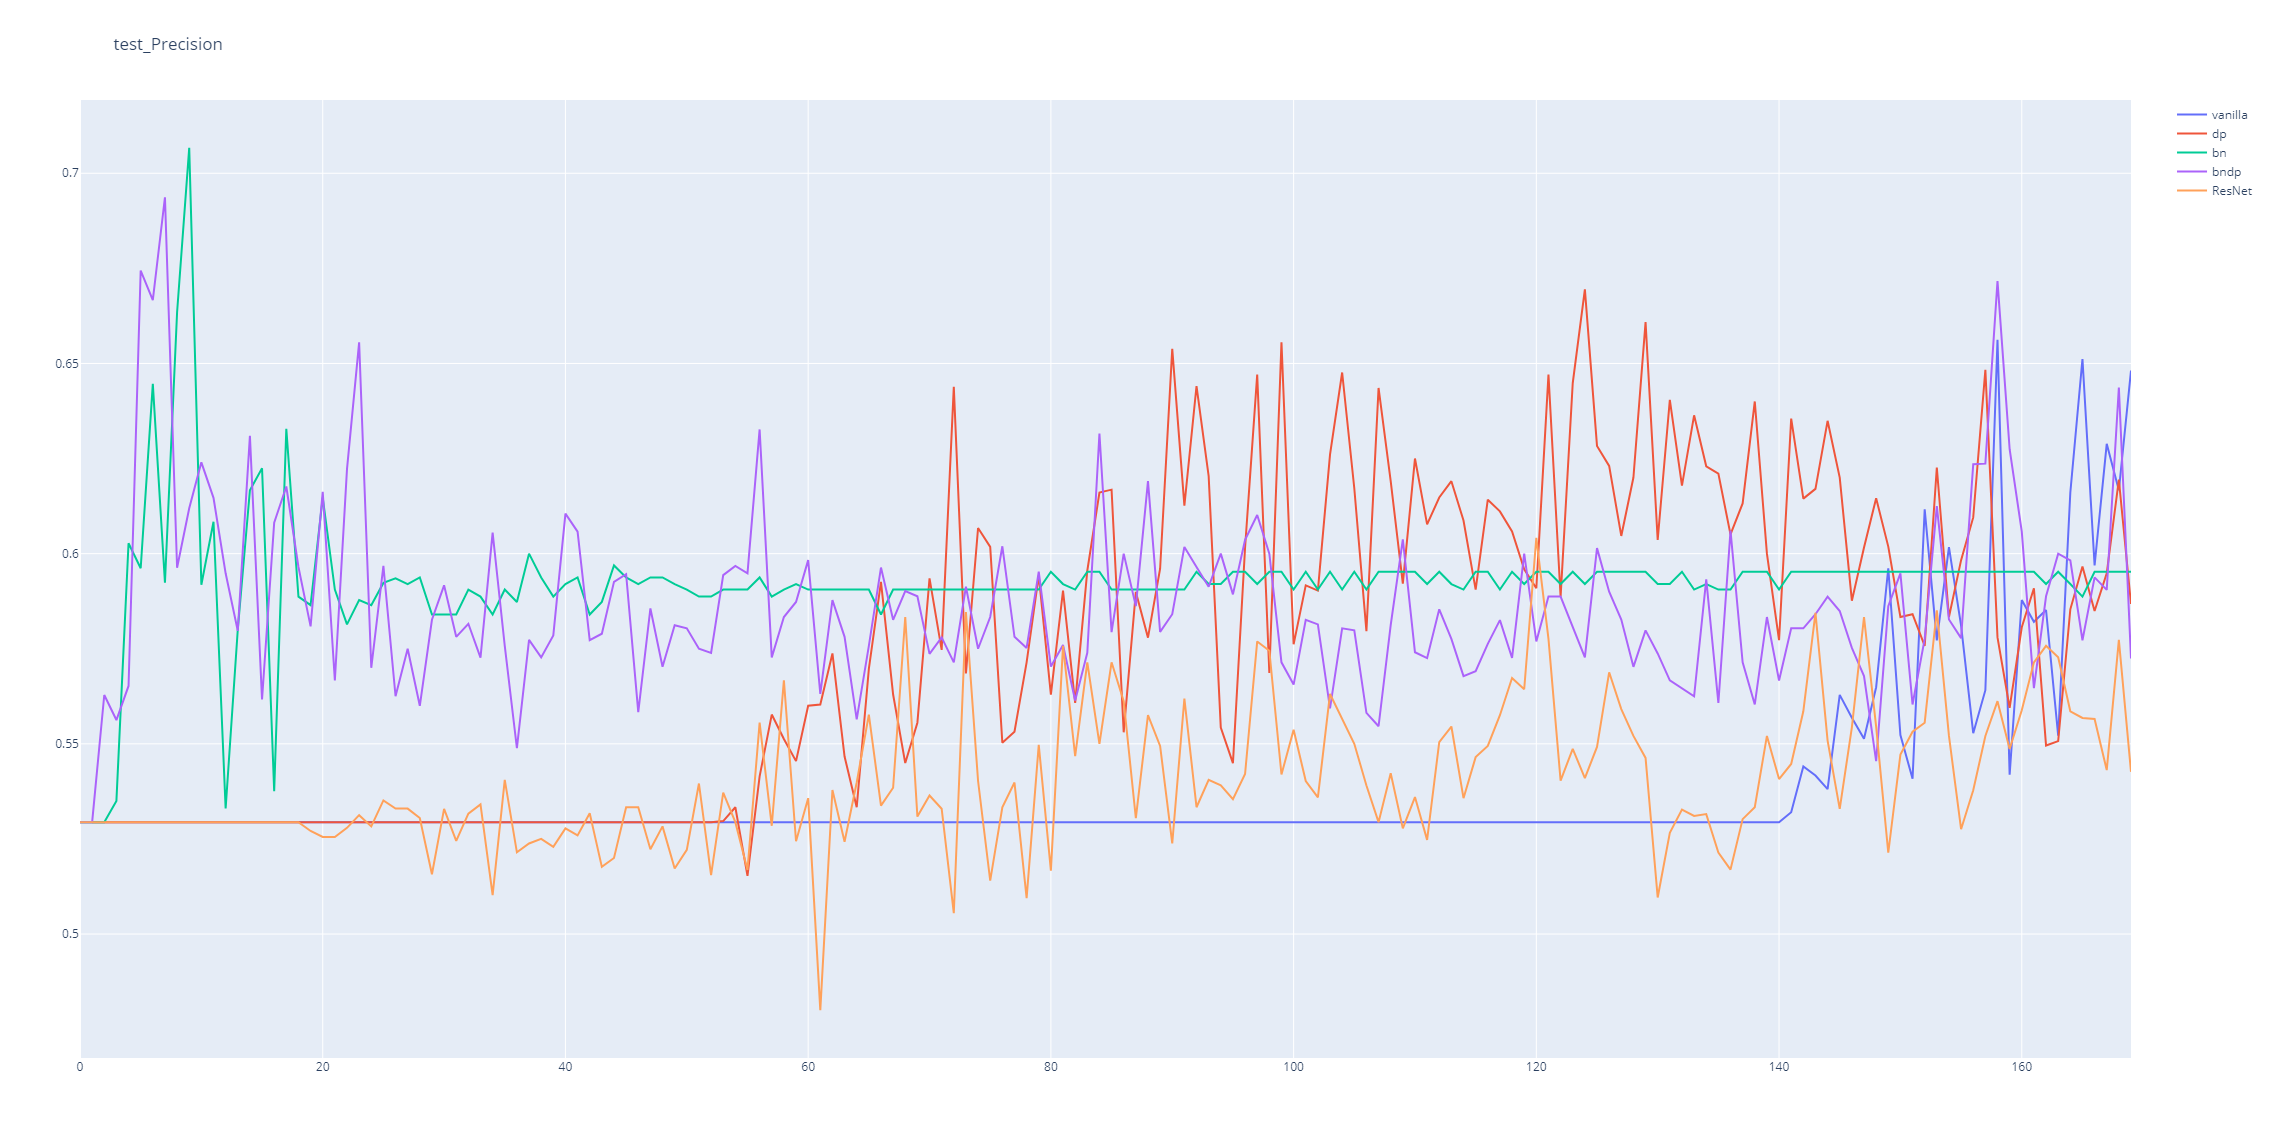
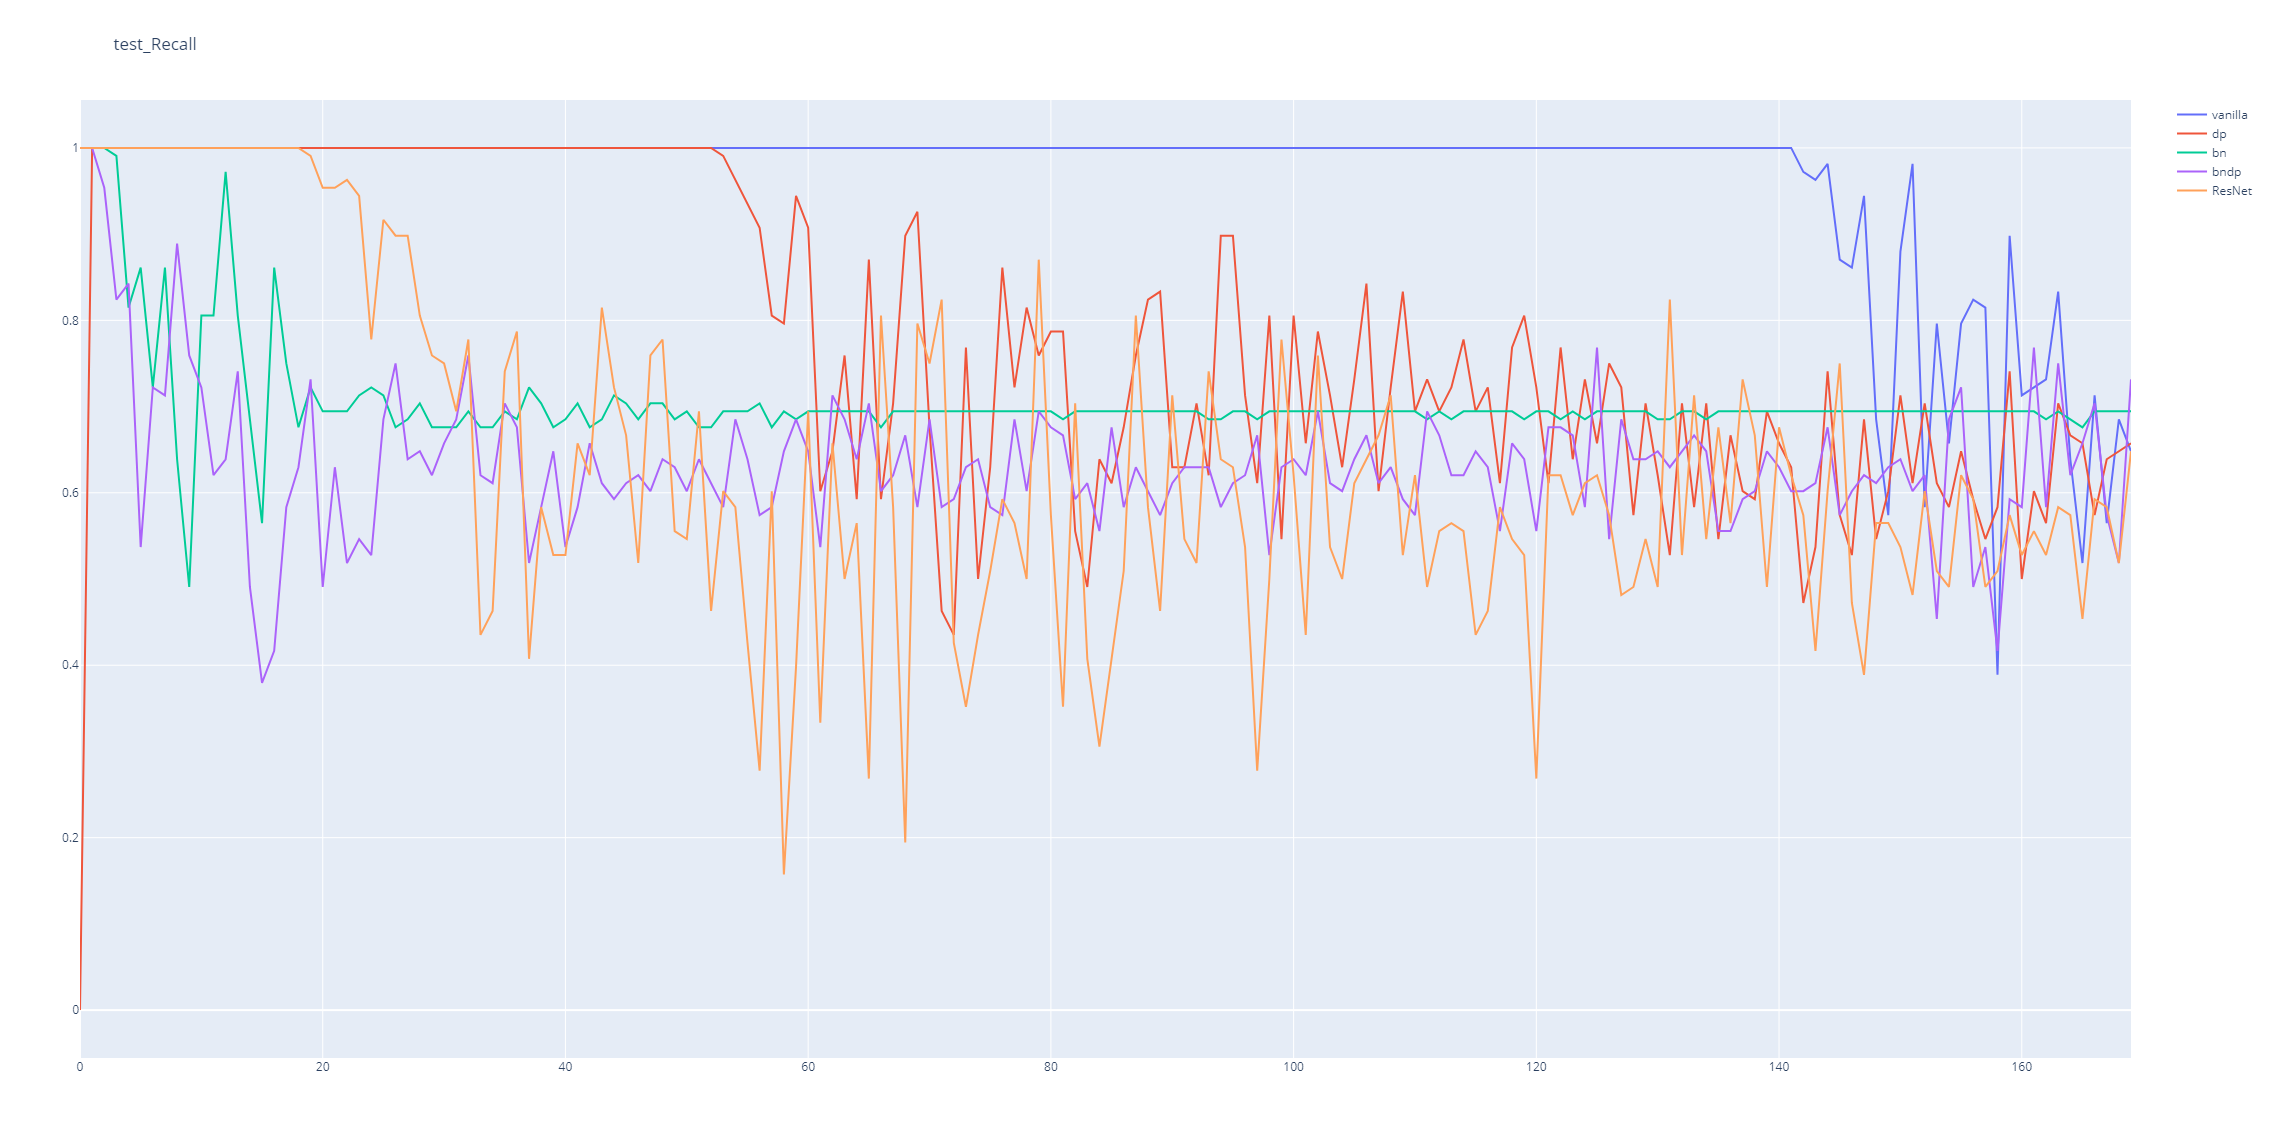
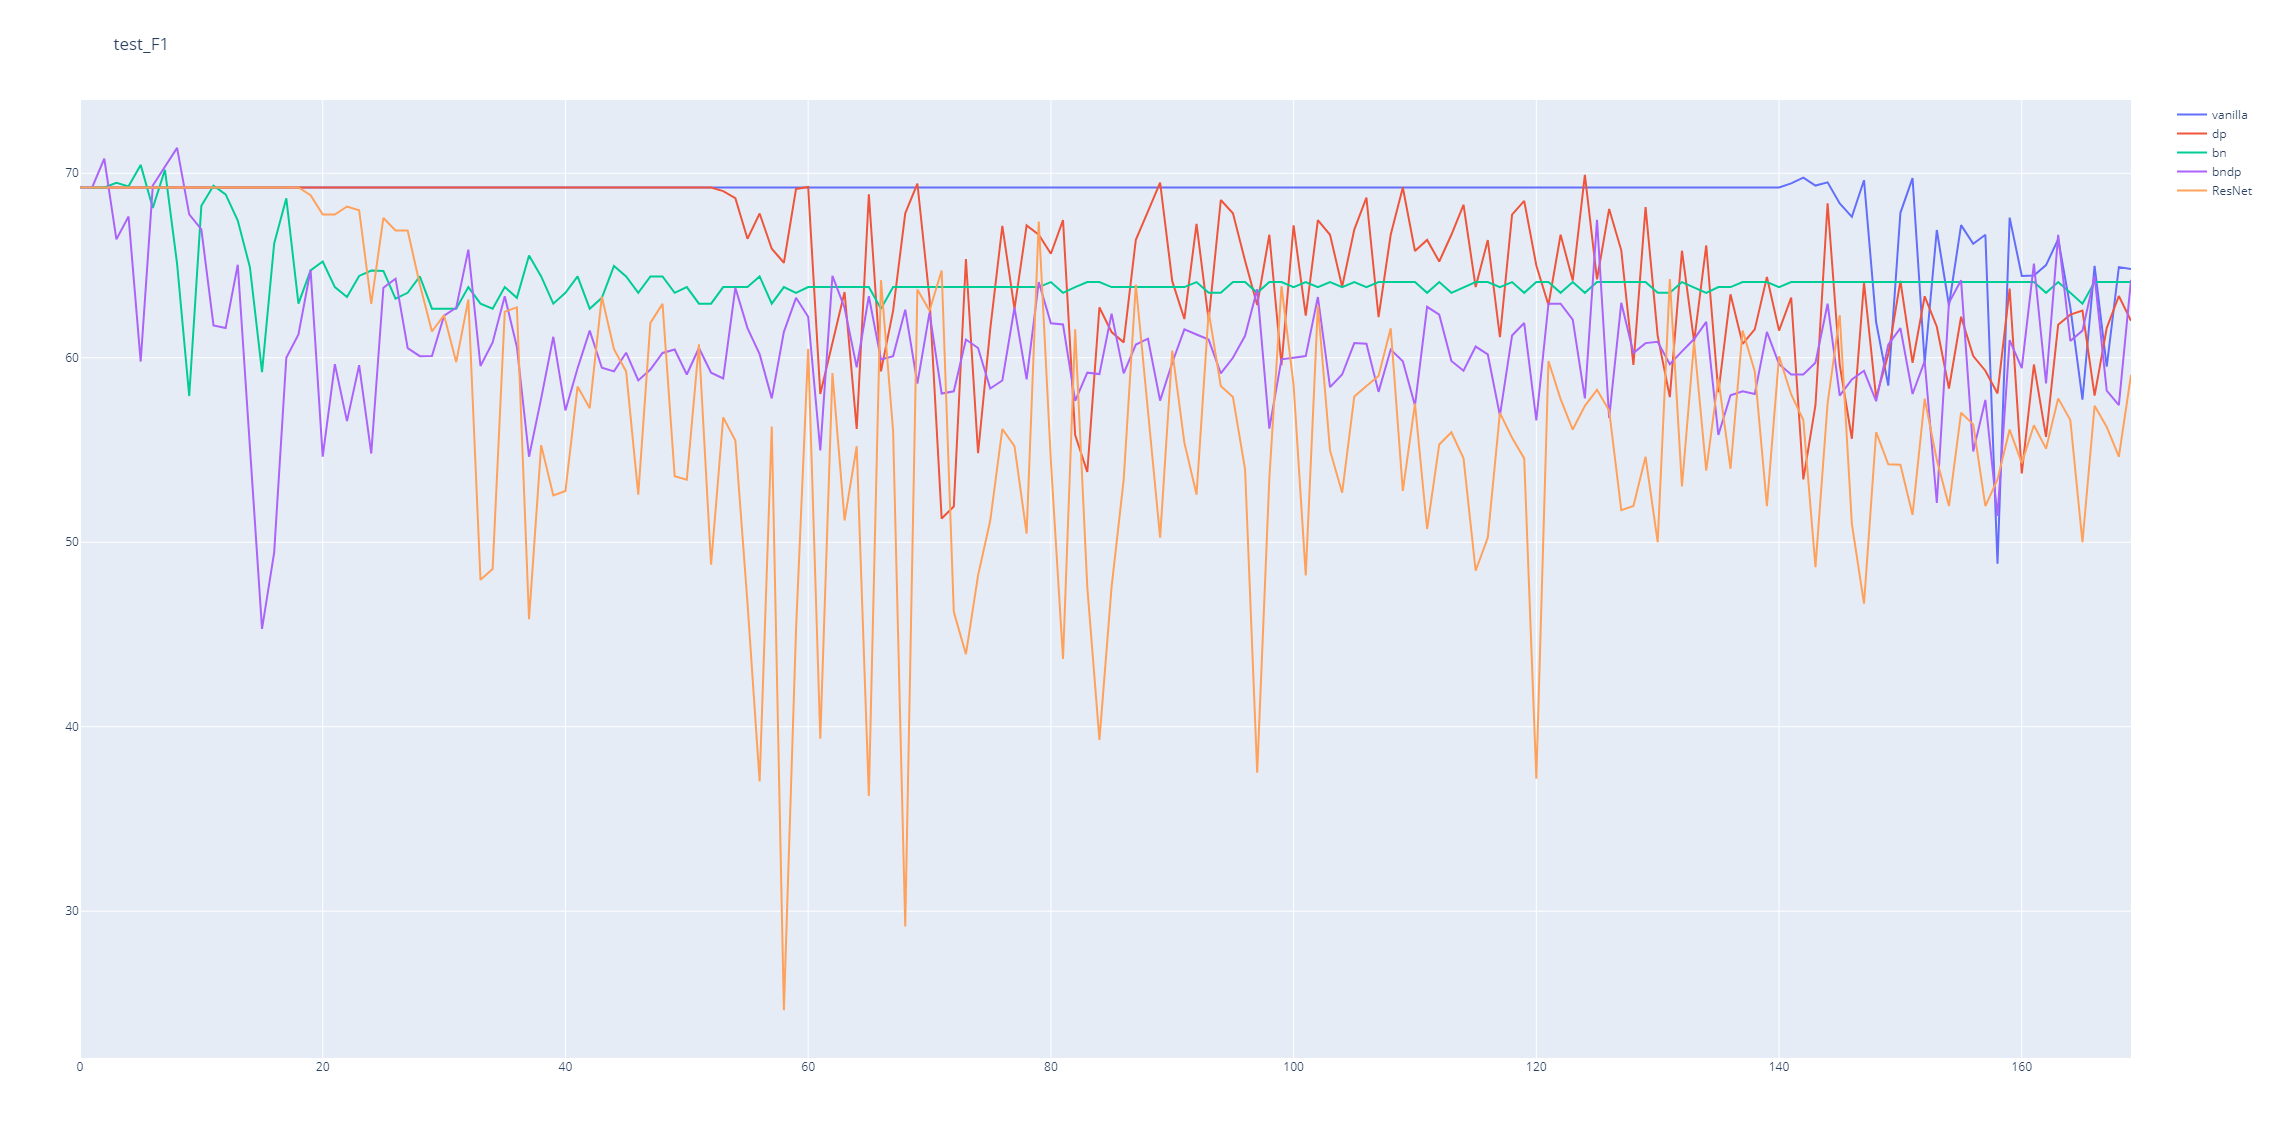

Notice:
- ResNet is unable to translate the in-sample performance to unseen data and osscilates around the random prediction point of 47%. 
- In general batch normalization outperforms the other configurations in terms of accuracy, yet a configuration with dropout alone does show an increase increase performance.
- The dp configuration shows consistently higher precision, recall and F1 scores and therefore should be considered the better model. This is also because in the region of dp's superiority the accuracy of bndp, dp and bn configurations is similar. 
    - once again it should be stated that the recall metric is the most important for this assignment as we want to detect fake images.
- Finally, the higher F1 score shows that the dp configuration is the overall better model. This is because F1 score presents a combination of recall and precision and can thus be compared if one model is better in either, but no clear superior is present. Of course the dp configuration already seems superior, yet it is also important to confirm this using the F1 score
    - In a more extensive setting it have been good to include the ROC curve for these configuration to indicate how much better every configuration is to a random guesser.

### Section 5.2: final notes and conclusion regarding comparison.
After these results have been discussed is seems clear that all proposed models are still mediocre. Therefore a couple of contradicting approaches are proposed as a first step in further research.
- It would be worthwhile to consider other model sizes with a greater variety of layers. This would expand the solution space and is useful to determine whether the limited setting of this research is holding back the out-of-sample performance. Of course when overfitting is encountered it seems contradictory to expand a model, yet if the out-of-sample performance is deemed inadequate the model apparently is focusing on the wrong features/representations. For example, introducing greater models but with larger bottlenecks could force the model to learn representations which are more beneficial for the task at hand.
- It would also be interesting to consider how much the training and test/validation set are similar. As mentioned before a distributional mismatch between the sets could explain this performance (assuming the model has adequately learnt the task). However, this might be difficult to prove and more creative measures would be required to define this mismatch. One of these would be to transform all images to grayscale and use filters similar to those used by a convolutional layer to determine if the sets have significantly different properties such as more edges/ sudden color differences.
- Finally, one could impose more overfitting features to determine what the absolute max in performance is that can be gained. This could serve as a first step before the previous two points are applied. These other overfitting features could include:
    - Conversion of hard to soft labelling for the real samples; this can be used to 'force' the model to predict fake more often than not. Can be seen as a weighting method. 
    - Further regularization e.g. by L1 or L2 regularization. Note that this was attempted, but did not provide any insightful improvements.
    - Weighting of specific samples with regard to their contribution to the overall loss.

## Chapter 6: Bonus, creativity required!
Some questions we would like you to think about and dig in the corners of your mind. You do not have to put your creative hurdles into action; we are just interested in any mind-blowing solutions you can think of.

### Question 1: if you had **unlimited** resources (think about 100 GPU's, 40GB each), what would be the best model for this task? How would you pick this model?
I would like to employ neuro-evolution or generative algorithms for defining model architectures with the aim to fight overfitting. This can in fact be achieved with far less resources than you propose, but would certainly benefit from it. This method opens another avenue to fight overfitting my letting another meta-model define the training process based on some metric. It can add and remove layers and through optimization and find an architecture which might be totally unexpected yet better than any proposed by another (human) designer. This type of technique bridges the gap between reinforcement learning and architecture design and has a good theoretical basis for (global) convergence. In a more practical sense, even if it would not convergence it might provide insights in potential model architectures other designers have not even considered. Thus through this method the best model for this task might be unknown, yet it could be optimized around a particular measure e.g. precision.

### Question 2: is **more** data always better?
No, this only applies whenever the distribution of this additional data resembles the 'true' distribution we are attempting to match. As the aim of any NN model design is to achieve high out-of-sample performance it is of paramount importance to keep considering the present mismatch in distribution between training and test sets. This is the reason that data augmentation techniques should be considered with caution; if applied they  further increase the distributional characteristics of the training sets even if they already showed a mismatch with reality. Besides the nature of the data, other aspects such as class imbalance (mentioned earlier) should be considered. When incorporating more data of a single class a model might be prone to predict said class simply due to the fact that the probability of being correct is higher. On the other hand ...

### Question 3: could you name a task that we would not be able to solve with DL?
Many tasks can be solved with DL as long as there is a strong enough (distributional) **connection** between the inputs and the outputs. The strenght of the connection can be diminished by multiple phenomena which make DL impractical to apply:
- There is not enough data to capture a large process. In other words using DL on small data sets can break down if the data does not contain enough information to predict an output. 
- The data's connection is weakened by noise. Noise can be present in many different formats such as a near-constant factor and anomalies. In some cases the data at hand can be so noisy that in the current representation DL will not do much better than random guessing in which case it can not be worthwhile to consider DL wrt to the effort it would take.
- The input and outputs are representations of an unobservable process and represented through latent variables. This is a more theoretical problem in which all the data you have should be considered in a much more stochastic setting than in normal cases.  Problems with unobserved variables such as an assets 'state' in a high-frequency environment is an example. This return probably is only a representation of a latent variable. In other words DL can have problems if the inputs and outputs are more and more based on unobserved variables.
- Related to the previous the curse of dimensionality can cause problems for DL. 
- Non-euclidean (non-vector) spaces also require completely different types of models in which case DL might have to be adapted.


# Deliverable
Send your notebook, Colab or code back to your contact person at DuckDuckGoose. We will contact you to schedule a demo. You are free to decide on the format of the demo.